In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
#ATTENTION : AMELIORATION POSSIBLE : RAJOUTER DES COUCHES DE DROPOUT (METS DE PARAMETRES RANDOMS A 0, AIDE A PREVENIR L'OVERFITTING)

class Encoder(tf.keras.Model):
    def __init__(self,dropout=0):
        super().__init__()

        self.conv1 = tf.keras.layers.Conv1D(filters=32,kernel_size=3,padding='valid',activation='relu')
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.drop1 = tf.keras.layers.Dropout(rate=dropout)
        self.maxpool1 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2,padding='valid')

        self.conv2 = tf.keras.layers.Conv1D(filters=64,kernel_size=3,padding='valid',activation='relu')
        self.norm2 = tf.keras.layers.BatchNormalization()
        self.drop2 = tf.keras.layers.Dropout(rate=dropout)
        self.maxpool2 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2,padding='valid')

        self.conv3 = tf.keras.layers.Conv1D(filters=128,kernel_size=3,padding='valid',activation='relu') #convolution
        self.norm3 = tf.keras.layers.BatchNormalization() #normalisation
        self.drop3 = tf.keras.layers.Dropout(rate=dropout)
        self.maxpool3 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2,padding='valid') #max pooling

        self.conv4 = tf.keras.layers.Conv1D(filters=256,kernel_size=3,padding='valid',activation='relu')
        self.norm4 =  tf.keras.layers.BatchNormalization()#convolution
        self.drop4 = tf.keras.layers.Dropout(rate=dropout)

    def call(self, inputs):
        
        res = self.conv1(inputs)
        res = self.norm1(res)
        res = self.drop1(res)
        res = self.maxpool1(res)
        
        res = self.conv2(res)
        res = self.norm2(res)
        res = self.drop2(res)
        res = self.maxpool2(res)
        
        res = self.conv3(res)
        res = self.norm3(res)
        res = self.drop3(res)
        res = self.maxpool3(res)
        
        res = self.conv4(res)
        res = self.norm4(res)
        res = self.drop4(res)
        
        return res
    
    

        

In [3]:
#construction du modèle de l'encodeur
encoder = Encoder()
input = tf.keras.Input(shape=(510,3))
output_encoder = encoder.call(input)
model_encoder = tf.keras.Model(inputs=input,outputs=output_encoder)

#affichage
model_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 510, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 508, 32)           320       
                                                                 
 batch_normalization (BatchN  (None, 508, 32)          128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 508, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 254, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 252, 64)           6208  

In [4]:
class TempPoolLayer(tf.keras.Model):

    def __init__(self,k_size,dropout=0):
        super().__init__()
        self.avg = tf.keras.layers.AveragePooling1D(pool_size=k_size, strides=k_size, padding="valid")
        self.conv = tf.keras.layers.Conv1D(filters=64,kernel_size=1,padding='valid',activation='relu')
        self.norm = tf.keras.layers.BatchNormalization()
        self.drop = tf.keras.layers.Dropout(dropout)
        self.upsamp = tf.keras.layers.UpSampling1D(size=k_size) #a voir, faut'il préciser une méthode d'interpolation ?
                                             
    def call(self, inputs):
        res = self.avg(inputs)
        res = self.conv(res)
        res = self.norm(res)
        res = self.drop(res)
        res = self.upsamp (res)
                                                    
        return res                                            
                                                    
  

In [5]:
#définition des 4 couches
tmp_layer1 = TempPoolLayer(5)
tmp_layer2 = TempPoolLayer(10)
tmp_layer3 = TempPoolLayer(20)
tmp_layer4 = TempPoolLayer(30)

#appel avec les inputs qui sortent de l'encodeur
input_tmp = output_encoder
output_tmp1 = tmp_layer1.call(input_tmp)
output_tmp2 = tmp_layer2.call(input_tmp)
output_tmp3 = tmp_layer3.call(input_tmp)
output_tmp4 = tmp_layer4.call(input_tmp)

#construction et affichage des modèles des couches parallèles (juste pour vérifier qu'on ait les bonnes tailles)
model_tmp1 = tf.keras.Model(inputs=input_tmp,outputs=output_tmp1) 
model_tmp2 = tf.keras.Model(inputs=input_tmp,outputs=output_tmp2) 
model_tmp3 = tf.keras.Model(inputs=input_tmp,outputs=output_tmp3) 
model_tmp4 = tf.keras.Model(inputs=input_tmp,outputs=output_tmp4) 

#affichage
model_tmp1.summary()
model_tmp2.summary()
model_tmp3.summary()
model_tmp4.summary()





Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 256)]         0         
                                                                 
 average_pooling1d (AverageP  (None, 12, 256)          0         
 ooling1D)                                                       
                                                                 
 conv1d_4 (Conv1D)           (None, 12, 64)            16448     
                                                                 
 batch_normalization_4 (Batc  (None, 12, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 12, 64)            0         
                                                                 
 up_sampling1d (UpSampling1D  (None, 60, 64)           0   

In [6]:
#concaténation
output_tmp_all = tf.keras.layers.Concatenate()([output_encoder, output_tmp1, output_tmp2, output_tmp3, output_tmp4])
model_tmp_all = tf.keras.Model(inputs=output_encoder,outputs=output_tmp_all)
model_tmp_all.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 60, 256)]    0           []                               
                                                                                                  
 average_pooling1d (AveragePool  (None, 12, 256)     0           ['input_6[0][0]']                
 ing1D)                                                                                           
                                                                                                  
 average_pooling1d_1 (AveragePo  (None, 6, 256)      0           ['input_6[0][0]']                
 oling1D)                                                                                         
                                                                                            

In [7]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1DTranspose(filters=32,kernel_size=8,strides=8,padding='valid')
        self.conv2 = tf.keras.layers.Conv1D(filters=4,kernel_size=1,strides=1,padding='valid') #4 car on check la puissance electrique de 4 appareils
    def call(self,inputs):
        res = self.conv1(inputs)
        res = self.conv2(res)
        return res

In [8]:
#construction du modele du décodeur
decoder = Decoder()
input_decoder = output_tmp_all
output_decoder = decoder.call(input_decoder)
model_decoder = tf.keras.Model(inputs=input_decoder ,outputs=output_decoder)

#affichage
model_decoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 60, 512)]         0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 480, 32)          131104    
 nspose)                                                         
                                                                 
 conv1d_8 (Conv1D)           (None, 480, 4)            132       
                                                                 
Total params: 131,236
Trainable params: 131,236
Non-trainable params: 0
_________________________________________________________________


In [9]:
#modele complet
CNN_model = tf.keras.Model(inputs=input,outputs=output_decoder)
CNN_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 510, 3)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 508, 32)      320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 508, 32)     128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 508, 32)      0           ['batch_normalization[0][0]

In [10]:
#Compilation du modèle
CNN_model.compile(optimizer='adam', #optimizer adam est une méthode d'optimisation, au même titre que la descente de gradient
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.losses.MeanAbsoluteError()])

In [11]:
#Chargement des données et nettoyage

%run "./preprocessing.ipynb"

In [12]:
#données : X et Y

#L_batch = 510
L_batch_X = 510
L_batch_Y = 480

#conversion des x et y en array
X_array = np.array(X)
Y_array = np.array(Y)
N = X_array.shape[0]

# #avec 4 dimensions de sortie
Nb_batchs = int(N/L_batch_X)

X_array_bis = np.zeros([Nb_batchs,L_batch_X,3])
Y_array_bis = np.zeros([Nb_batchs,L_batch_Y,4])

for i in range(1,3):
    X_array_bis[:,:,i] = tf.reshape(X_array[0:L_batch_X*Nb_batchs,i],[Nb_batchs,L_batch_X])

X_tensor = tf.transpose(X_array_bis,perm=[0,1,2])
    

for i in range(1,4):
  Y_array_bis[:,:,i] = np.reshape(Y_array[0:L_batch_Y*Nb_batchs,i],[Nb_batchs,L_batch_Y])

Y_tensor = tf.transpose(Y_array_bis,perm=[0,1,2])
#intervertir dimensions 1 et 2 (donc 2ème et 3ème dimension)


In [13]:
print(Nb_batchs)
print(X_array.shape)
print(Y_array.shape)

print(X_tensor.shape)
print(Y_array_bis.shape)
print(Y_tensor.shape)


#on doit avoir 
#X.shape = (N_batches,510)
#Y.shape = (N_batches,480)

831
(423913, 3)
(399640, 4)
(831, 510, 3)
(831, 480, 4)
(831, 480, 4)


In [14]:
def shuffle(X,Y):
    print ("X Y : ",X.shape, Y.shape)
    X = X.numpy()
    Y = Y.numpy()
    print ("X Y : ",X.shape, Y.shape)

    #indices
    N = X.shape[0]
    indices = [i for i in range(N)]
    randperm = tf.random.shuffle(indices)

    #copies de X et Y
    X_shuff = tf.constant(X[randperm[0]].copy());
    Y_shuff = tf.constant(Y[randperm[0]].copy());
    print("deb",X_shuff.shape," ",Y_shuff.shape)


    # boucle 
    for i in randperm[1:]:
        X_shuff = tf.concat([X_shuff,X[i,:].copy()],axis=0)
        Y_shuff = tf.concat([Y_shuff,Y[i,:,:].copy()],axis=0)


    
    return X_shuff,Y_shuff



X_shuff,Y_shuff = shuffle(X_tensor,Y_tensor)
X_shuff,Y_shuff = X_tensor,Y_tensor


part=(int) (4*X_shuff.shape[0]/5)


X_shuff_train=X_shuff[:part]
X_shuff_validation=X_shuff[part:]
Y_shuff_train=Y_shuff[:part,:]
Y_shuff_validation=Y_shuff[part:,:]


X Y :  (831, 510, 3) (831, 480, 4)
X Y :  (831, 510, 3) (831, 480, 4)
deb (510, 3)   (480, 4)


In [15]:
tf.config.run_functions_eagerly(True)
history=CNN_model.fit(x=X_shuff, y=Y_shuff, epochs=300,batch_size=32,validation_data=(X_shuff_validation,Y_shuff_validation))

/home/boyer/.local/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/300
26/26 [==============================] - 7s 277ms/step - loss: 0.8888 - mean_absolute_error: 0.5380 - val_loss: 1.0734 - val_mean_absolute_error: 0.4361
Epoch 2/300
26/26 [==============================] - 7s 281ms/step - loss: 0.7754 - mean_absolute_error: 0.4560 - val_loss: 1.0728 - val_mean_absolute_error: 0.4282
Epoch 3/300
26/26 [==============================] - 7s 280ms/step - loss: 0.7641 - mean_absolute_error: 0.4470 - val_loss: 1.0769 - val_mean_absolute_error: 0.4225
Epoch 4/300
26/26 [==============================] - 7s 279ms/step - loss: 0.7589 - mean_absolute_error: 0.4415 - val_loss: 1.0767 - val_mean_absolute_error: 0.4243
Epoch 5/300
26/26 [==============================] - 7s 274ms/step - loss: 0.7629 - mean_absolute_error: 0.4466 - val_loss: 1.0759 - val_mean_absolute_error: 0.4296
Epoch 6/300
26/26 [==============================] - 7s 278ms/step - loss: 0.7612 - mean_absolute_error: 0.4420 - val_loss: 1.0815 - val_mean_absolute_error: 0.4285
Epoch 7/30

26/26 [==============================] - 7s 277ms/step - loss: 0.6342 - mean_absolute_error: 0.3810 - val_loss: 0.9430 - val_mean_absolute_error: 0.3865
Epoch 51/300
26/26 [==============================] - 7s 275ms/step - loss: 0.6269 - mean_absolute_error: 0.3759 - val_loss: 0.9288 - val_mean_absolute_error: 0.3695
Epoch 52/300
26/26 [==============================] - 7s 273ms/step - loss: 0.6221 - mean_absolute_error: 0.3768 - val_loss: 0.9574 - val_mean_absolute_error: 0.3866
Epoch 53/300
26/26 [==============================] - 7s 276ms/step - loss: 0.6248 - mean_absolute_error: 0.3781 - val_loss: 1.0124 - val_mean_absolute_error: 0.3775
Epoch 54/300
26/26 [==============================] - 7s 273ms/step - loss: 0.6118 - mean_absolute_error: 0.3714 - val_loss: 0.9956 - val_mean_absolute_error: 0.3764
Epoch 55/300
26/26 [==============================] - 7s 275ms/step - loss: 0.6043 - mean_absolute_error: 0.3684 - val_loss: 0.9083 - val_mean_absolute_error: 0.3720
Epoch 56/300
26/2

26/26 [==============================] - 7s 275ms/step - loss: 0.4500 - mean_absolute_error: 0.2985 - val_loss: 0.8088 - val_mean_absolute_error: 0.3307
Epoch 100/300
26/26 [==============================] - 7s 276ms/step - loss: 0.4435 - mean_absolute_error: 0.2948 - val_loss: 0.8684 - val_mean_absolute_error: 0.3293
Epoch 101/300
26/26 [==============================] - 7s 276ms/step - loss: 0.4406 - mean_absolute_error: 0.2947 - val_loss: 0.8071 - val_mean_absolute_error: 0.3132
Epoch 102/300
26/26 [==============================] - 7s 277ms/step - loss: 0.4312 - mean_absolute_error: 0.2892 - val_loss: 0.9824 - val_mean_absolute_error: 0.3152
Epoch 103/300
26/26 [==============================] - 7s 273ms/step - loss: 0.4382 - mean_absolute_error: 0.2936 - val_loss: 0.8419 - val_mean_absolute_error: 0.3126
Epoch 104/300
26/26 [==============================] - 7s 275ms/step - loss: 0.4297 - mean_absolute_error: 0.2908 - val_loss: 1.0262 - val_mean_absolute_error: 0.3162
Epoch 105/30

26/26 [==============================] - 7s 282ms/step - loss: 0.3581 - mean_absolute_error: 0.2531 - val_loss: 0.8791 - val_mean_absolute_error: 0.2805
Epoch 149/300
26/26 [==============================] - 7s 278ms/step - loss: 0.3587 - mean_absolute_error: 0.2532 - val_loss: 0.8446 - val_mean_absolute_error: 0.2803
Epoch 150/300
26/26 [==============================] - 7s 275ms/step - loss: 0.3557 - mean_absolute_error: 0.2509 - val_loss: 0.9051 - val_mean_absolute_error: 0.2764
Epoch 151/300
26/26 [==============================] - 7s 277ms/step - loss: 0.3548 - mean_absolute_error: 0.2528 - val_loss: 0.8715 - val_mean_absolute_error: 0.2738
Epoch 152/300
26/26 [==============================] - 7s 275ms/step - loss: 0.3520 - mean_absolute_error: 0.2500 - val_loss: 0.8495 - val_mean_absolute_error: 0.2704
Epoch 153/300
26/26 [==============================] - 7s 274ms/step - loss: 0.3515 - mean_absolute_error: 0.2494 - val_loss: 0.8919 - val_mean_absolute_error: 0.2725
Epoch 154/30

26/26 [==============================] - 8s 292ms/step - loss: 0.3283 - mean_absolute_error: 0.2392 - val_loss: 0.7403 - val_mean_absolute_error: 0.2572
Epoch 198/300
26/26 [==============================] - 8s 292ms/step - loss: 0.3330 - mean_absolute_error: 0.2430 - val_loss: 1.8046 - val_mean_absolute_error: 0.2909
Epoch 199/300
26/26 [==============================] - 8s 290ms/step - loss: 0.3472 - mean_absolute_error: 0.2509 - val_loss: 0.9882 - val_mean_absolute_error: 0.2880
Epoch 200/300
26/26 [==============================] - 8s 291ms/step - loss: 0.3359 - mean_absolute_error: 0.2443 - val_loss: 0.9190 - val_mean_absolute_error: 0.2901
Epoch 201/300
26/26 [==============================] - 8s 292ms/step - loss: 0.3372 - mean_absolute_error: 0.2470 - val_loss: 0.8400 - val_mean_absolute_error: 0.2731
Epoch 202/300
26/26 [==============================] - 8s 291ms/step - loss: 0.3300 - mean_absolute_error: 0.2416 - val_loss: 0.8061 - val_mean_absolute_error: 0.2629
Epoch 203/30

26/26 [==============================] - 7s 281ms/step - loss: 0.3011 - mean_absolute_error: 0.2269 - val_loss: 0.8743 - val_mean_absolute_error: 0.2489
Epoch 247/300
26/26 [==============================] - 7s 281ms/step - loss: 0.3041 - mean_absolute_error: 0.2288 - val_loss: 0.8219 - val_mean_absolute_error: 0.2554
Epoch 248/300
26/26 [==============================] - 7s 285ms/step - loss: 0.3041 - mean_absolute_error: 0.2296 - val_loss: 0.8069 - val_mean_absolute_error: 0.2497
Epoch 249/300
26/26 [==============================] - 7s 283ms/step - loss: 0.2982 - mean_absolute_error: 0.2241 - val_loss: 0.8230 - val_mean_absolute_error: 0.2497
Epoch 250/300
26/26 [==============================] - 7s 283ms/step - loss: 0.2996 - mean_absolute_error: 0.2259 - val_loss: 0.8299 - val_mean_absolute_error: 0.2517
Epoch 251/300
26/26 [==============================] - 7s 281ms/step - loss: 0.2983 - mean_absolute_error: 0.2248 - val_loss: 0.8319 - val_mean_absolute_error: 0.2455
Epoch 252/30

26/26 [==============================] - 7s 277ms/step - loss: 0.2841 - mean_absolute_error: 0.2178 - val_loss: 0.8227 - val_mean_absolute_error: 0.2443
Epoch 296/300
26/26 [==============================] - 7s 276ms/step - loss: 0.2842 - mean_absolute_error: 0.2202 - val_loss: 0.8333 - val_mean_absolute_error: 0.2442
Epoch 297/300
26/26 [==============================] - 7s 276ms/step - loss: 0.2834 - mean_absolute_error: 0.2178 - val_loss: 0.7876 - val_mean_absolute_error: 0.2372
Epoch 298/300
26/26 [==============================] - 7s 281ms/step - loss: 0.2800 - mean_absolute_error: 0.2160 - val_loss: 0.7713 - val_mean_absolute_error: 0.2378
Epoch 299/300
26/26 [==============================] - 7s 289ms/step - loss: 0.2841 - mean_absolute_error: 0.2203 - val_loss: 0.7668 - val_mean_absolute_error: 0.2398
Epoch 300/300
26/26 [==============================] - 7s 280ms/step - loss: 0.2827 - mean_absolute_error: 0.2181 - val_loss: 2.0358 - val_mean_absolute_error: 0.2602


In [16]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = CNN_model.evaluate(X_shuff_validation, Y_shuff_validation, batch_size=1)
print("test loss, test mean,_absolute_error:", results)




Evaluate on test data
167/167 [==============================] - 6s 35ms/step - loss: 2.0358 - mean_absolute_error: 0.2626
test loss, test mean,_absolute_error: [2.035766124725342, 0.2625764012336731]


In [17]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`


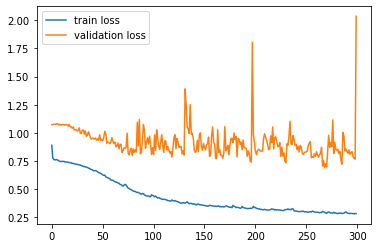

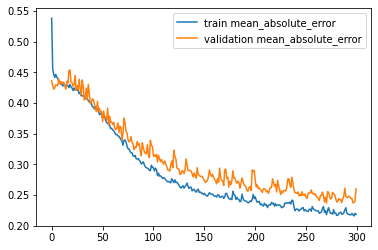

In [18]:
plt.plot(history.history.get('loss'), label='train loss')
plt.plot(history.history.get('val_loss'), label = 'validation loss')
plt.legend()
plt.show()

plt.plot(history.history.get('mean_absolute_error'), label='train mean_absolute_error')
plt.plot(history.history.get('val_mean_absolute_error'), label='validation mean_absolute_error')
plt.legend()
plt.show()

In [19]:
predictions = CNN_model.predict(X_shuff_validation)

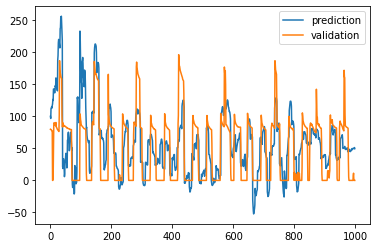

In [20]:
p1=[]
p2=[]
pre=predictions
a=1
for i in range (0,10):
    for j in range (480):
        p1.append(predictions[i,j,a]*Ystock[a][1]+Ystock[a][0])
        p2.append(Y_shuff_validation[i,j,a]*Ystock[a][1]+Ystock[a][0])

r=2000
plt.plot(p1[r+1000:r+2000],label="prediction")
plt.plot(p2[r+1000:r+2000],label="validation")
plt.legend()
plt.show()

In [21]:
CNN_model.save("model")

INFO:tensorflow:Assets written to: model/assets
